## TODO
- [x] import data and atlases
- [ ] select only Dosenbach's ROIs
- [x] parcellate
- [x] extract timeseries
- [x] calc ROI-ROI correlations
- [x] partial correlations
- [x] tangent embedding 
- [x] plot connectome
- [x] fit connectome to some randomly generated summary stat
- [x] transform fitted model to connectome
- [x] plot ROI networks
- [ ] use actual beh data

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import nilearn
from nilearn import plotting, datasets, masking
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVR

from bids import BIDSLayout

In [2]:
layout = BIDSLayout('data/julia2018/bids', derivatives=True)
subjects = layout.get_subject()

In [3]:

images = layout.get(task='rest', desc='preproc', suffix='bold', scope='derivatives', extension='nii.gz', return_type='filename')
mask_images = layout.get(task='rest', desc='brain', suffix='mask', scope='derivatives', extension='nii.gz', return_type='filename')
confounds_files = layout.get(task='rest', desc='confounds', suffix='timeseries', scope='derivatives', extension='tsv', return_type='filename')

# random behehavioral scores (TODO: load actual beh scores)
beh_features = np.array([np.random.randn() * 100. for s in subjects])


Now, we want to verify masks by plotting them as ROIs. Let's plot the first mask and the first image.

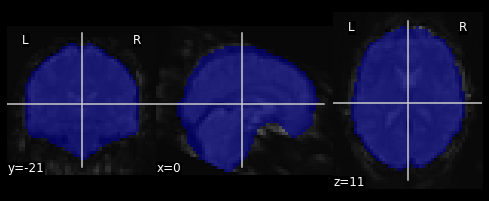

In [4]:
from nilearn import image

# data = []
# # TODO: order filenames or match them
# for img, mask in zip(images, masks):
#     data.append(masking.apply_mask(img, mask))

mean_img = image.mean_img(images[0])
plotting.plot_roi(mask_images[0], mean_img)

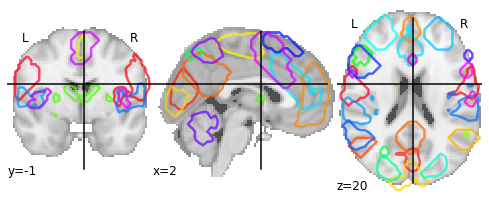

In [5]:
# MSDL atlas
msdl = datasets.fetch_atlas_msdl()
msdl_coords = plotting.find_probabilistic_atlas_cut_coords(msdl.maps)
plotting.plot_prob_atlas(msdl.maps)


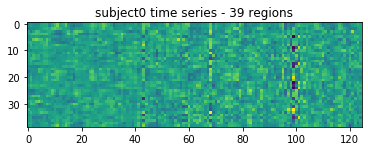

In [6]:
# %% 2. extract ROI time series
timeseries = []

# for a more structured strategy to define confounds see https://github.com/SIMEXP/load_confounds
# confounds imputation: for a discussion on missing values in confounds see https://github.com/poldracklab/fitlins/issues/56
confounds_cols = ['trans_x', 'trans_y', 'trans_z','rot_x','rot_y','rot_z','global_signal','a_comp_cor_00','a_comp_cor_01']

for img, mask_img, confounds in zip(images, mask_images, confounds_files):
    # using "memory='tmp/nilearn_cache'" makes this fail
    masker = NiftiMapsMasker(msdl.maps, mask_img = mask_img, standardize=True)
    confounds = pd.read_csv(confounds, sep='\t')[confounds_cols].values
    ts = masker.fit_transform(img, confounds=confounds)
    timeseries.append(ts)

timeseries = np.array(timeseries)

plt.imshow(timeseries[0].T)
plt.title('subject0 time series - {} regions'.format(timeseries[0].shape[1]))
plt.show()

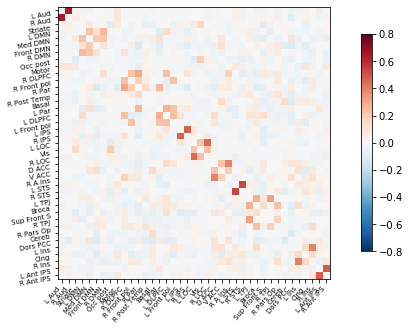

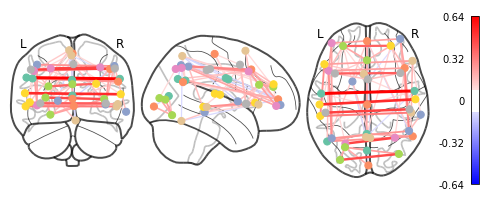

In [7]:
measures = ['correlation', 'partial correlation', 'tangent']

conn_matrices = {}
conn_measures = {}

for m in measures:
    conn_measures[m] = ConnectivityMeasure(kind=m)
    conn_matrices[m] = conn_measures[m].fit_transform(timeseries)[0]


# visualize mean partial correlation

conn_matrix = conn_measures['partial correlation'].mean_

np.fill_diagonal(conn_matrix, 0)  # improves visualization!

plotting.plot_matrix(conn_matrix, labels=msdl.labels,
                     vmax=0.8, vmin=-0.8,
                     colorbar=True)

disp = plotting.plot_connectome(conn_matrix, msdl_coords,
                                edge_threshold="90%",
                                colorbar=True)

plt.show()


In [8]:
# %% 4. model behavioral data using resting state connectivities


cv = KFold(n_splits=3, shuffle=True)



for m in measures:
    pooled_mse = []
    for train, test in cv.split(timeseries, beh_features):
        conn_measure = ConnectivityMeasure(kind=m, vectorize=True)
        connectomes = conn_measure.fit_transform(timeseries[train])
        model = SVR(kernel='linear').fit(connectomes, beh_features[train])
        # make predictions for the left-out test subjects
        y_true = beh_features[test]
        y_pred = model.predict(conn_measure.transform(timeseries[test]))
        # store the accuracy for this cross-validation fold
        mse = mean_squared_error(y_true, y_pred)
        pooled_mse.append(mse)

    print(f'{m} MSE (3 folds):', np.mean(pooled_mse))


correlation MSE (3 folds): 14044.190500555645
partial correlation MSE (3 folds): 15306.677075550158
tangent MSE (3 folds): 13674.214100792638


MSE:
	correlation: 9136.22
	partial correlation: 8149.53
	tangent: 8217.29


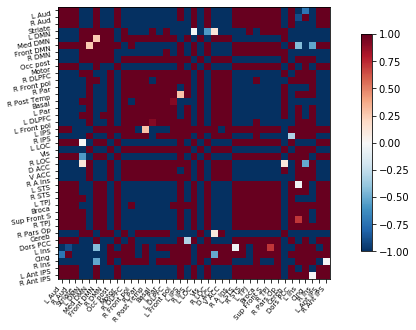

In [9]:
from pprint import pprint

X_train, X_test, y_train, y_test = \
    train_test_split(timeseries, beh_features, test_size=0.2, random_state=0)

mse = {}
for m in measures:
    cm = ConnectivityMeasure(kind=m, vectorize=True)
    connectome = cm.fit_transform(X_train)
    model = SVR(kernel='linear').fit(connectome, y_train)
    y_pred = model.predict(conn_measure.transform(X_test))
    mse[m] = mean_squared_error(y_test, y_pred)

print('MSE:')
for k, v in mse.items():
    print(f'\t{k}: {v:.2f}')



cm = ConnectivityMeasure(kind='tangent', vectorize=True)#, discard_diagonal=True)
connectomes = cm.fit_transform(timeseries)
model = SVR(kernel='linear').fit(connectomes, beh_features)
coef_map = cm.inverse_transform(model.coef_).squeeze()
plotting.plot_matrix(coef_map, labels=msdl.labels,
                     vmax=1., vmin=-1.,
                     colorbar=True)

# disp = plotting.plot_connectome(coef_map, msdl_coords,
#                                 edge_threshold="80%",
#                                 colorbar=True)
# plt.show()

### Experiment: Plot connectivity networks using NetworkX/Bokeh

Loading BokehJS ...

None

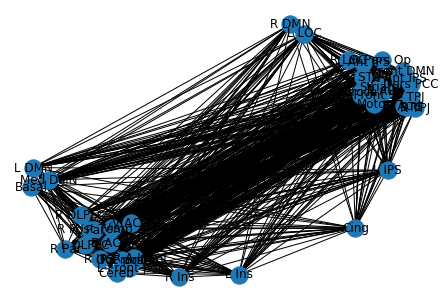

In [40]:
from IPython.display import display

import networkx as nx

from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from bokeh.models import (Circle, EdgesAndLinkedNodes, HoverTool, 
                         MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,                           WheelZoomTool)
from bokeh.plotting import from_networkx
output_notebook(resources=INLINE)

G = nx.from_numpy_matrix(coef_map)
G = nx.relabel_nodes(G, lambda x: msdl.labels[x])

display(nx.draw_spring(G, with_labels=True))


plot = Plot(x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))
plot.title.text = "ROIs interactions"

graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0,0))
graph_renderer.node_renderer.data_source.data['label'] = msdl.labels

hover = HoverTool(tooltips=[("ROI", "@label")])
plot.add_tools(hover, TapTool(), WheelZoomTool())

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color='green')
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color='red')

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

graph_renderer.selection_policy = NodesAndLinkedEdges()

plot.renderers.append(graph_renderer)

show(plot)